# Binary Classification Model for Kaggle Tabular Playground Series October 2021 Using Python and AutoKeras
### David Lowe
### January 18, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground October 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the biological response of molecules given various chemical properties. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: After a series of tuning trials, the best AutoKeras model processed the training dataset with a ROC/AUC score of 0.8431. When we processed the test dataset with the final model, the model achieved a ROC/AUC score of 0.8441.

CONCLUSION: In this iteration, the AutoKeras model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 October Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-oct-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-oct-2021/leaderboard

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jan 14 04:47:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A4000           Off  | 00000000:00:05.0 Off |                  Off |
| 41%   39C    P8    14W / 140W |      0MiB / 16117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 47.3 gigabytes of available RAM



In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


In [5]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
import keras_tuner
import autokeras as ak

2022-01-14 04:47:39.470162: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [9]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = [tf.keras.metrics.AUC()]
MAX_EPOCHS = 10
BATCH_SIZE = 32
MAX_TRIALS = 10

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.2


2022-01-14 04:47:40.596506: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-14 04:47:40.615166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 04:47:40.615778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: RTX A4000 computeCapability: 8.6
coreClock: 1.56GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2022-01-14 04:47:40.615794: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-14 04:47:40.660746: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-14 04:47:40.660820: I tensorflow/stream_executor/platform/default/

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [13]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021oct/train.csv

In [14]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id        f0        f1        f2        f3        f4        f5        f6  \
0   0  0.205979  0.410993  0.176775  0.223581  0.423543  0.476140  0.413590   
1   1  0.181004  0.473119  0.011734  0.213657  0.619678  0.441593  0.230407   
2   2  0.182583  0.307431  0.325950  0.207116  0.605699  0.309695  0.493337   
3   3  0.180240  0.494592  0.008367  0.223580  0.760618  0.439211  0.432055   
4   4  0.177172  0.495513  0.014263  0.548819  0.625396  0.562493  0.117158   

         f7        f8  ...  f276  f277  f278  f279  f280  f281  f282  f283  \
0  0.612021  0.534873  ...     0     1     0     0     0     0     0     0   
1  0.686013  0.281971  ...     0     1     0     0     0     0     0     0   
2  0.751107  0.536272  ...     0     0     0     1     1     0     0     0   
3  0.776147  0.483958  ...     0     0     0     0     1     0     0     0   
4  0.561255  0.077115  ...     0     1     1     0     1     0     0     1   

   f284  target  
0     0       1  
1     0       1  
2 

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 287 columns):
 #    Column  Dtype  
---   ------  -----  
 0    id      int64  
 1    f0      float64
 2    f1      float64
 3    f2      float64
 4    f3      float64
 5    f4      float64
 6    f5      float64
 7    f6      float64
 8    f7      float64
 9    f8      float64
 10   f9      float64
 11   f10     float64
 12   f11     float64
 13   f12     float64
 14   f13     float64
 15   f14     float64
 16   f15     float64
 17   f16     float64
 18   f17     float64
 19   f18     float64
 20   f19     float64
 21   f20     float64
 22   f21     float64
 23   f22     int64  
 24   f23     float64
 25   f24     float64
 26   f25     float64
 27   f26     float64
 28   f27     float64
 29   f28     float64
 30   f29     float64
 31   f30     float64
 32   f31     float64
 33   f32     float64
 34   f33     float64
 35   f34     float64
 36   f35     float64
 37   f36     float64
 38   f

In [16]:
print(df_dataset_import.describe())

                   id              f0              f1              f2  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean    499999.500000        0.214334        0.460218        0.129253   
std     288675.278932        0.053320        0.101316        0.120805   
min          0.000000        0.041790        0.022016        0.000381   
25%     249999.750000        0.181676        0.389215        0.017692   
50%     499999.500000        0.204498        0.453893        0.095496   
75%     749999.250000        0.229684        0.526023        0.177717   
max     999999.000000        1.000000        0.959019        0.994818   

                   f3              f4              f5              f6  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.277598        0.580710        0.416619        0.386532   
std          0.063163        0.115338        0.058231        0.133457   
min          0.000000        0.000000        0.000

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
f0        0
f1        0
f2        0
f3        0
         ..
f281      0
f282      0
f283      0
f284      0
target    0
Length: 287, dtype: int64
Total number of NaN in the dataframe:  0


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    499515
1    500485
dtype: int64


### 1.d) Data Cleaning

In [19]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

         f0        f1        f2        f3        f4        f5        f6  \
0  0.205979  0.410993  0.176775  0.223581  0.423543  0.476140  0.413590   
1  0.181004  0.473119  0.011734  0.213657  0.619678  0.441593  0.230407   
2  0.182583  0.307431  0.325950  0.207116  0.605699  0.309695  0.493337   
3  0.180240  0.494592  0.008367  0.223580  0.760618  0.439211  0.432055   
4  0.177172  0.495513  0.014263  0.548819  0.625396  0.562493  0.117158   

         f7        f8        f9  ...  f276  f277  f278  f279  f280  f281  \
0  0.612021  0.534873  0.147295  ...     0     1     0     0     0     0   
1  0.686013  0.281971  0.238509  ...     0     1     0     0     0     0   
2  0.751107  0.536272  0.286813  ...     0     0     0     1     1     0   
3  0.776147  0.483958  0.260886  ...     0     0     0     0     1     0   
4  0.561255  0.077115  0.158321  ...     0     1     1     0     1     0   

   f282  f283  f284  target  
0     0     0     0       1  
1     0     0     0       1  
2 

In [20]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 286 columns):
 #    Column  Dtype  
---   ------  -----  
 0    f0      float64
 1    f1      float64
 2    f2      float64
 3    f3      float64
 4    f4      float64
 5    f5      float64
 6    f6      float64
 7    f7      float64
 8    f8      float64
 9    f9      float64
 10   f10     float64
 11   f11     float64
 12   f12     float64
 13   f13     float64
 14   f14     float64
 15   f15     float64
 16   f16     float64
 17   f17     float64
 18   f18     float64
 19   f19     float64
 20   f20     float64
 21   f21     float64
 22   f22     int64  
 23   f23     float64
 24   f24     float64
 25   f25     float64
 26   f26     float64
 27   f27     float64
 28   f28     float64
 29   f29     float64
 30   f30     float64
 31   f31     float64
 32   f32     float64
 33   f33     float64
 34   f34     float64
 35   f35     float64
 36   f36     float64
 37   f37     float64
 38   f

In [21]:
print(df_dataset_import.describe())

                   f0              f1              f2              f3  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.214334        0.460218        0.129253        0.277598   
std          0.053320        0.101316        0.120805        0.063163   
min          0.041790        0.022016        0.000381        0.000000   
25%          0.181676        0.389215        0.017692        0.235342   
50%          0.204498        0.453893        0.095496        0.264669   
75%          0.229684        0.526023        0.177717        0.305837   
max          1.000000        0.959019        0.994818        0.979797   

                   f4              f5              f6              f7  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.580710        0.416619        0.386532        0.654858   
std          0.115338        0.058231        0.133457        0.065158   
min          0.000000        0.000959        0.000

In [22]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

f0        0
f1        0
f2        0
f3        0
f4        0
         ..
f281      0
f282      0
f283      0
f284      0
target    0
Length: 286, dtype: int64
Total number of NaN in the dataframe:  0


In [23]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    499515
1    500485
dtype: int64


### 1.e) Splitting Data into Sets

In [24]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (1000000, 286) df_features_train.shape: (1000000, 285) df_target_train.shape: (1000000,)


### 1.f) Set up the parameters for data visualization

In [25]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [26]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

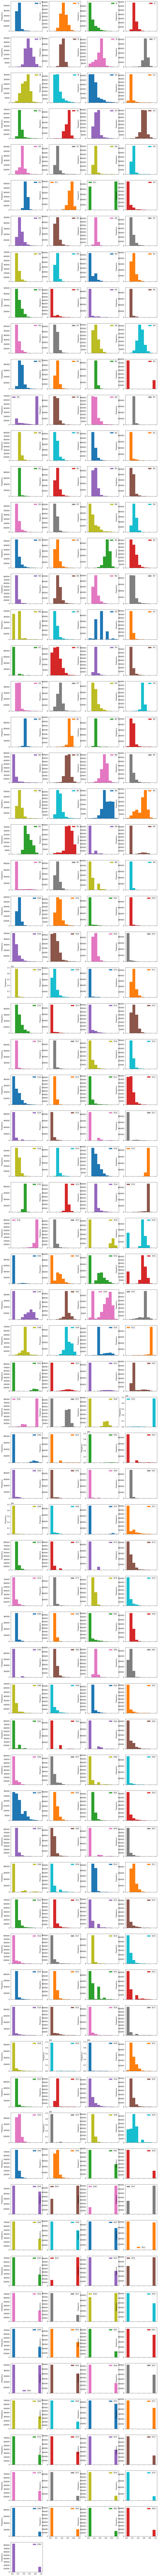

In [28]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

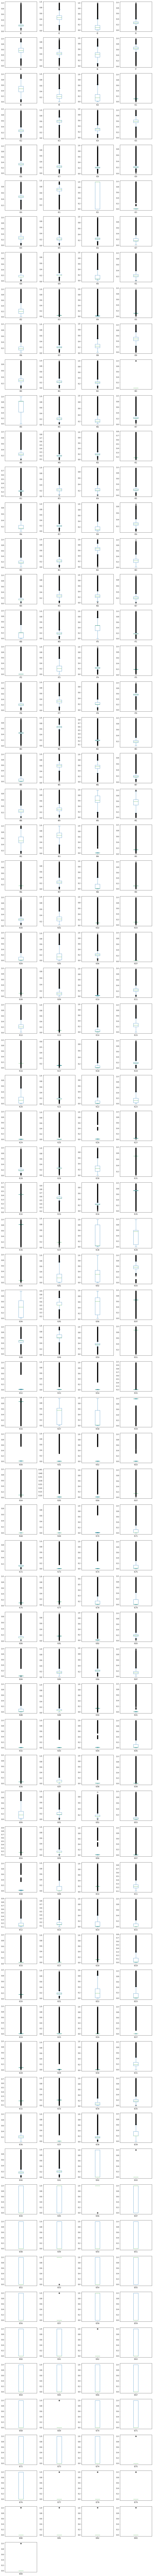

In [29]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [30]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [31]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [32]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [33]:
# # Compose pipeline for the numerical and categorical features (Block #1 of 2)
# numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
# numeric_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
#     ('scaler', preprocessing.MinMaxScaler())
# ])
# categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
# categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
#     ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

# print("Number of numerical columns:", len(numeric_columns))
# print("Number of categorical columns:", len(categorical_columns))
# print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

In [34]:
# # Compose pipeline for the numerical and categorical features (Block #2 of 2)
# preprocessor = compose.ColumnTransformer(transformers=[
#     ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
# ])

# # Display the shapes of the training dataset for final inspection
# array_features_train = preprocessor.fit_transform(df_features_train)
# print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

### 3.b) Training Data Balancing

In [35]:
# Not applicable for this iteration of the project

In [36]:
# Examine the target classes for imbalanced distribution
# Xy_original.groupby('targetVar').size()

In [37]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [38]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=RNG_SEED)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=RNG_SEED)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Display the Final Datasets for Model-Building

In [39]:
# Finalize the training dataset for the modeling activities
array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (1000000, 285) array_target_train.shape: (1000000,)


In [40]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [41]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [42]:
start_time_module = datetime.now()
reset_random()
auto_model = ak.StructuredDataClassifier(loss=DEFAULT_LOSS,
                                      metrics=DEFAULT_METRICS,
                                      max_trials=MAX_TRIALS,
                                      objective=keras_tuner.Objective("val_auc", direction="max"),
                                      seed=RNG_SEED)
auto_model.fit(x=array_features_train,
               y=array_target_train,
               epochs=MAX_EPOCHS,
               validation_split=VAL_SET_RATIO,
               batch_size=BATCH_SIZE,
               verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Trial 10 Complete [01h 08m 40s]
val_auc: 0.8431025743484497

Best val_auc So Far: 0.8432372808456421
Total elapsed time: 10h 57m 56s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
31250/31250 [==============================] - 347s 11ms/step - loss: 0.5075 - auc: 0.8308
Epoch 2/10
31250/31250 [==============================] - 345s 11ms/step - loss: 0.4956 - auc: 0.8374
Epoch 3/10
31250/31250 [==============================] - 346s 11ms/step - loss: 0.4919 - auc: 0.8400
Epoch 4/10
31250/31250 [==============================] - 346s 11ms/step - loss: 0.4897 - auc: 0.8415
Epoch 5/10
31250/31250 [==============================] - 344s 11ms/step - loss: 0.4881 - auc: 0.8425
Epoch 6/10
31250/31250 [==============================] - 345s 11ms/step - loss: 0.4869 - auc: 0.8433
Epoch 7/10
31250/31250 [==============================] - 345s 11ms/step - loss: 0.4862 - auc: 0.8438
Epoch 8/10
31250/31250 [==============================] - 346s 11ms/step - loss: 0.4853 - auc: 0.8443
Epoch 9/10
31

2022-01-14 17:14:52.540984: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
Total time for model fitting: 12:23:14.623002


In [43]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [44]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [45]:
final_model = auto_model.export_model()
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 285)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 285)               0         
_________________________________________________________________
normalization (Normalization (None, 285)               571       
_________________________________________________________________
dense (Dense)                (None, 32)                9152      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056  

### 5.b) Load Test Dataset and Make Predictions

In [46]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021oct/test.csv

In [47]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

        id        f0        f1        f2        f3        f4        f5  \
0  1000000  0.178216  0.435617  0.010230  0.202074  0.390170  0.324221   
1  1000001  0.181250  0.476455  0.022413  0.283146  0.598020  0.349508   
2  1000002  0.159721  0.451202  0.259649  0.365274  0.594634  0.413502   
3  1000003  0.182424  0.520976  0.095344  0.327742  0.741830  0.358711   
4  1000004  0.229329  0.336513  0.023511  0.300913  0.668738  0.481586   

         f6        f7        f8  ...  f275  f276  f277  f278  f279  f280  \
0  0.221722  0.738894  0.582588  ...     1     0     0     0     0     0   
1  0.283467  0.721575  0.268990  ...     0     0     0     0     0     0   
2  0.249318  0.642339  0.411104  ...     0     0     0     0     0     0   
3  0.270077  0.601662  0.297742  ...     0     0     0     0     0     1   
4  0.545660  0.667849  0.546045  ...     0     0     0     0     1     0   

   f281  f282  f283  f284  
0     1     1     1     0  
1     0     0     0     0  
2     1     0 

In [48]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

        id
0  1000000
1  1000001
2  1000002
3  1000003
4  1000004


In [49]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

         f0        f1        f2        f3        f4        f5        f6  \
0  0.178216  0.435617  0.010230  0.202074  0.390170  0.324221  0.221722   
1  0.181250  0.476455  0.022413  0.283146  0.598020  0.349508  0.283467   
2  0.159721  0.451202  0.259649  0.365274  0.594634  0.413502  0.249318   
3  0.182424  0.520976  0.095344  0.327742  0.741830  0.358711  0.270077   
4  0.229329  0.336513  0.023511  0.300913  0.668738  0.481586  0.545660   

         f7        f8        f9  ...  f275  f276  f277  f278  f279  f280  \
0  0.738894  0.582588  0.343770  ...     1     0     0     0     0     0   
1  0.721575  0.268990  0.208373  ...     0     0     0     0     0     0   
2  0.642339  0.411104  0.246891  ...     0     0     0     0     0     0   
3  0.601662  0.297742  0.252829  ...     0     0     0     0     0     1   
4  0.667849  0.546045  0.202731  ...     0     0     0     0     1     0   

   f281  f282  f283  f284  
0     1     1     1     0  
1     0     0     0     0  
2     1 

In [50]:
# Finalize the test dataset for the testing activities
array_features_test = df_features_test.to_numpy()
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (500000, 285) to array_features_test.shape: (500000, 285)


In [51]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[[0.7298967 ]
 [0.34652242]
 [0.93986446]
 ...
 [0.24971515]
 [0.6229864 ]
 [0.29438385]]


In [52]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021oct/sample_submission.csv'
df_sample_submission = pd.read_csv(dataset_path, index_col=False)
df_sample_submission.drop(columns=['id'], inplace=True)
submission_header = list(df_sample_submission.columns)
print(submission_header)

['target']


In [53]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

        id    target
0  1000000  0.729897
1  1000001  0.346522
2  1000002  0.939864
3  1000003  0.740759
4  1000004  0.274460


In [54]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20220114-1717.csv


In [55]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 12:30:04.980643
